In [1]:
import pandas as pd
import geopandas as gp
import maup

# Community_Change_GA_OH_05_10_2024

We received a request to aggregate income data to precincts in Georgia and healthcare coverage data to precincts in Ohio.

For Georgia, we used [2022 income data by household](https://redistrictingdatahub.org/dataset/georgia-2022-select-income-data-from-the-american-community-survey-20182022-at-the-block-group-level/) at the block group level. This data was disaggregated to the block level using household counts from the Decennial PL 2020 H1 data, which was pulled from the census website. Each block was assigned a portion of households based on its share of totals households of its block group. Block data was assigned to 2022 precincts using the precinct of greatest area overlap. Lastly, an estimated median income was assigned to each precinct by take the median household income range from among all the household income counts assigned to each precincts.

For Ohio, we used healthcare coverage data from census tables B27015. Data was disaggregated down to the block level using a ratio of each block's share of tract population.

# Georgia

In [2]:
ga_income = pd.read_csv("./raw-from-source/ga_inc_2022_bg/ga_inc_2022_bg.csv")
ga_income["GEOID"] = ga_income["GEOID"].astype(str)

ga_hh = pd.read_csv("./raw-from-source/DECENNIALPL2020.H1_2024-05-13T155911/DECENNIALPL2020.H1-Data.csv", header = 1)
ga_hh.drop(["Unnamed: 5"], axis = 1, inplace = True)
ga_hh["BG_ID20"] = ga_hh["Geography"].str[9:-3]



In [3]:
ga_joined = pd.merge(ga_hh, ga_income, left_on = "BG_ID20", right_on = "GEOID", how = "left")
ga_joined["BG_HH"] = ga_joined.groupby("BG_ID20")[' !!Total:!!Occupied'].transform(sum)
ga_joined["BG_HH_ratio"] = ga_joined[' !!Total:!!Occupied']/ga_joined['BG_HH']
income_cols = [i for i in list(ga_joined.columns) if i[-2:]=="22" and i not in ["MEDN_INC22","TOT_HOUS22"]]

for col in income_cols:
    ga_joined[col+"_BLOCK"] = ga_joined[col]*ga_joined["BG_HH_ratio"]
    
ga_joined["GEOID20"] =  ga_joined["Geography"].str[9:]

In [4]:
ga_blocks_shp = gp.read_file("/Users/peterhorton/Documents/RDH/raw_data/census/2020_TIGER_B/ga_b_2020_bound.zip")

ga_joined_shps = gp.GeoDataFrame(pd.merge(ga_blocks_shp, ga_joined, on = "GEOID20", how = "outer", indicator = True))


In [5]:
ga_precinct = gp.read_file("./raw-from-source/ga_2022_gen_prec/ga_2022_gen_prec_no_splits/ga_2022_gen_prec_no_splits.shp")
ga_precinct.set_index("UNIQUE_ID", inplace = True)

In [6]:
ga_joined_shps["PREC"] = maup.assign(ga_joined_shps, ga_precinct)

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:15: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometry.index = i
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:16: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self.spatial_index = STRtree(self.geometries)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:16: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self.spatial_index = STRtree(self.geometries)
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.p

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed com

In [7]:
ga_income_precs = ga_joined_shps.groupby("PREC").sum()
ga_income_precs.reset_index(inplace = True, drop = False)
ga_income_precs.drop(["COUNTYFP",'ALAND20',
 'AWATER20'], axis = 1, inplace = True)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_71534/2846103825.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ga_income_precs = ga_joined_shps.groupby("PREC").sum()


In [8]:
ga_final_final = gp.GeoDataFrame(pd.merge(ga_precinct, ga_income_precs, right_on = "PREC", left_on = "UNIQUE_ID", how = "left"))
print(ga_final_final[ga_final_final["75K_100K22_BLOCK"].isna()])
ga_final_final = ga_final_final.fillna(0)

     COUNTYFP  county precinct  G22A01NO  G22A01YES  G22A02NO  G22A02YES  \
1587      121  Fulton    SS07D       0.0        1.0       0.0        1.0   
1625      121  Fulton    UC02C       8.0       34.0       3.0       40.0   

      G22AGRDHEM  G22AGRLRAU  G22AGRRHAR  ...  35K_40K22_BLOCK  \
1587         0.0         0.0         1.0  ...              NaN   
1625        38.0         4.0         2.0  ...              NaN   

      40K_45K22_BLOCK  45K_50K22_BLOCK  50K_60K22_BLOCK  60K_75K22_BLOCK  \
1587              NaN              NaN              NaN              NaN   
1625              NaN              NaN              NaN              NaN   

      75K_100K22_BLOCK  100_125K22_BLOCK  125_150K22_BLOCK  150_200K22_BLOCK  \
1587               NaN               NaN               NaN               NaN   
1625               NaN               NaN               NaN               NaN   

      200K_MOR22_BLOCK  
1587               NaN  
1625               NaN  

[2 rows x 454 columns]


In [9]:
ga_final_final.drop([ 'STATEFP','MEDN_INC22','TOT_HOUS22','LESS_10K22',
 '10K_15K22','15K_20K22',
 '20K_25K22','25K_30K22','30K_35K22','35K_40K22','40K_45K22',
 '45K_50K22','50K_60K22','60K_75K22','75K_100K22','100_125K22',
 '125_150K22','150_200K22','200K_MOR22','BG_HH','BG_HH_ratio',],axis = 1, inplace = True)

ga_final_final.rename(columns = {i:i.replace("_BLOCK","") for i in list(ga_final_final.columns)}, inplace = True)

In [10]:
ga_final_final.rename(columns = {' !!Total:':'TOT_HH',
 ' !!Total:!!Occupied':"HH_OCC",
 ' !!Total:!!Vacant':"HH_VAC",'PREC':'UNIQUE_ID'}, inplace = True)

In [11]:
def find_med(x):
    tot_house = x[['LESS_10K22',
     '10K_15K22',
     '15K_20K22',
     '20K_25K22',
     '25K_30K22',
     '30K_35K22',
     '35K_40K22',
     '40K_45K22',
     '45K_50K22',
     '50K_60K22',
     '60K_75K22',
     '75K_100K22',
     '100_125K22',
     '125_150K22',
     '150_200K22',
     '200K_MOR22']].sum()
    
    running_sum = 0
    
    for count in ['LESS_10K22',
     '10K_15K22',
     '15K_20K22',
     '20K_25K22',
     '25K_30K22',
     '30K_35K22',
     '35K_40K22',
     '40K_45K22',
     '45K_50K22',
     '50K_60K22',
     '60K_75K22',
     '75K_100K22',
     '100_125K22',
     '125_150K22',
     '150_200K22',
     '200K_MOR22']:
        running_sum += x[count]
        if running_sum>=tot_house/2:
            return int(count.split("_")[1][:-3].replace("MO","250"))*1000
    
ga_final_final["Med_Est"] = ga_final_final.apply(lambda x: find_med(x), axis = 1)    

<AxesSubplot: >

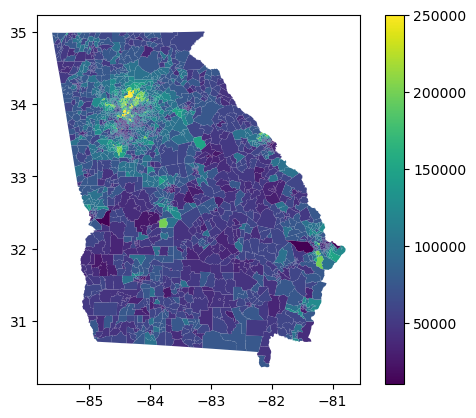

In [12]:
ga_final_final.plot(column = "Med_Est", legend = True)

In [13]:
list(ga_final_final.columns)

['COUNTYFP',
 'county',
 'precinct',
 'G22A01NO',
 'G22A01YES',
 'G22A02NO',
 'G22A02YES',
 'G22AGRDHEM',
 'G22AGRLRAU',
 'G22AGRRHAR',
 'G22ATGDJOR',
 'G22ATGLCOW',
 'G22ATGRCAR',
 'G22GOVDABR',
 'G22GOVLHAZ',
 'G22GOVRKEM',
 'G22INSDROB',
 'G22INSRKIN',
 'G22LABDBOD',
 'G22LABLAND',
 'G22LABRTHO',
 'G22LTGDBAI',
 'G22LTGLGRA',
 'G22LTGRJON',
 'G22RFANO',
 'G22RFAYES',
 'G22RFBNO',
 'G22RFBYES',
 'G22SOSDNGU',
 'G22SOSLMET',
 'G22SOSRRAF',
 'G22SUPDSEA',
 'G22SUPRWOO',
 'G22USSDWAR',
 'G22USSLOLI',
 'G22USSRWAL',
 'GCON01DHER',
 'GCON01RCAR',
 'GCON02DBIS',
 'GCON02RWES',
 'GCON03DALM',
 'GCON03RFER',
 'GCON04DJOH',
 'GCON04RCHA',
 'GCON05DWIL',
 'GCON05RZIM',
 'GCON06DCHR',
 'GCON06RMCC',
 'GCON07DMCB',
 'GCON07RGON',
 'GCON08DBUT',
 'GCON08RSCO',
 'GCON09DFOR',
 'GCON09RCLY',
 'GCON10DJOH',
 'GCON10RCOL',
 'GCON11DDAZ',
 'GCON11RLOU',
 'GCON12DJOH',
 'GCON12RALL',
 'GCON13DSCO',
 'GCON13RGON',
 'GCON14DFLO',
 'GCON14RGRE',
 'GSL001RCAM',
 'GSL002RTAR',
 'GSL003RHOR',
 'GSL004RCAR',


In [14]:
ga_final_final

,COUNTYFP,county,precinct,G22A01NO,G22A01YES,G22A02NO,G22A02YES,G22AGRDHEM,G22AGRLRAU,G22AGRRHAR,...,40K_45K22,45K_50K22,50K_60K22,60K_75K22,75K_100K22,100_125K22,125_150K22,150_200K22,200K_MOR22,Med_Est
0,1,Appling,1B,83.0,690.0,84.0,694.0,77.0,8.0,731.0,...,0.034653,16.449087,61.498567,40.154680,125.279876,53.820139,42.618759,68.579181,22.564587,60000
1,1,Appling,1C,64.0,532.0,55.0,548.0,43.0,5.0,576.0,...,17.462133,31.323575,41.746713,35.721984,75.266083,32.494346,14.526648,12.533645,11.997969,35000
2,1,Appling,2,163.0,782.0,111.0,859.0,608.0,19.0,398.0,...,25.978187,68.112943,267.053383,126.994199,149.985379,24.616027,57.074169,79.118910,72.377812,50000
3,1,Appling,3A1,77.0,434.0,62.0,454.0,17.0,2.0,503.0,...,0.690265,16.944570,32.775708,24.398264,67.504562,31.293407,31.380531,60.318087,12.887597,60000
4,1,Appling,3C,110.0,778.0,88.0,811.0,180.0,10.0,739.0,...,38.254051,13.368703,71.936594,94.562507,64.039824,37.308890,41.432248,50.273430,29.477187,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,215,Muscogee,215FTBEN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068293,0.051220,0.116260,0.300000,0.314634,0.064228,0.033333,0.006504,0.004878,75000
2728,215,Muscogee,215FTBEN2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.765854,28.324390,64.291870,165.900000,173.992683,35.517886,18.433333,3.596748,2.697561,75000
2729,215,Muscogee,215FTBEN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.293375,32.097792,81.561514,98.280757,82.287066,121.006309,42.646688,65.000000,16.555205,75000
2730,215,Muscogee,215FTBEN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.526829,33.395122,75.801626,195.600000,205.141463,41.876423,21.733333,4.240650,3.180488,75000


In [15]:
ga_final_final = ga_final_final[['UNIQUE_ID','COUNTYFP',
 'county',
 'precinct',
 'TOT_HH',
 'HH_OCC',
 'HH_VAC',
 'LESS_10K22',
 '10K_15K22',
 '15K_20K22',
 '20K_25K22',
 '25K_30K22',
 '30K_35K22',
 '35K_40K22',
 '40K_45K22',
 '45K_50K22',
 '50K_60K22',
 '60K_75K22',
 '75K_100K22',
 '100_125K22',
 '125_150K22',
 '150_200K22',
 '200K_MOR22',
 'Med_Est', 'G22A01NO',
 'G22A01YES',
 'G22A02NO',
 'G22A02YES',
 'G22AGRDHEM',
 'G22AGRLRAU',
 'G22AGRRHAR',
 'G22ATGDJOR',
 'G22ATGLCOW',
 'G22ATGRCAR',
 'G22GOVDABR',
 'G22GOVLHAZ',
 'G22GOVRKEM',
 'G22INSDROB',
 'G22INSRKIN',
 'G22LABDBOD',
 'G22LABLAND',
 'G22LABRTHO',
 'G22LTGDBAI',
 'G22LTGLGRA',
 'G22LTGRJON',
 'G22RFANO',
 'G22RFAYES',
 'G22RFBNO',
 'G22RFBYES',
 'G22SOSDNGU',
 'G22SOSLMET',
 'G22SOSRRAF',
 'G22SUPDSEA',
 'G22SUPRWOO',
 'G22USSDWAR',
 'G22USSLOLI',
 'G22USSRWAL',
 'GCON01DHER',
 'GCON01RCAR',
 'GCON02DBIS',
 'GCON02RWES',
 'GCON03DALM',
 'GCON03RFER',
 'GCON04DJOH',
 'GCON04RCHA',
 'GCON05DWIL',
 'GCON05RZIM',
 'GCON06DCHR',
 'GCON06RMCC',
 'GCON07DMCB',
 'GCON07RGON',
 'GCON08DBUT',
 'GCON08RSCO',
 'GCON09DFOR',
 'GCON09RCLY',
 'GCON10DJOH',
 'GCON10RCOL',
 'GCON11DDAZ',
 'GCON11RLOU',
 'GCON12DJOH',
 'GCON12RALL',
 'GCON13DSCO',
 'GCON13RGON',
 'GCON14DFLO',
 'GCON14RGRE',
 'GSL001RCAM',
 'GSL002RTAR',
 'GSL003RHOR',
 'GSL004RCAR',
 'GSL005RBAR',
 'GSL006RRID',
 'GSL007RRAL',
 'GSL008DKRI',
 'GSL008RGUN',
 'GSL009RWAD',
 'GSL010RAND',
 'GSL011DHOL',
 'GSL011RJAS',
 'GSL012RLUM',
 'GSL013RDEM',
 'GSL014RSCO',
 'GSL015RGAM',
 'GSL016RKEL',
 'GSL017DMAR',
 'GSL017RMOM',
 'GSL018DRHU',
 'GSL018RSMI',
 'GSL019DCOY',
 'GSL019RGUL',
 'GSL020RBYR',
 'GSL021RTHO',
 'GSL022DHIL',
 'GSL022RRID',
 'GSL023RBAL',
 'GSL024DWAL',
 'GSL024RBAR',
 'GSL025DMEY',
 'GSL025RJON',
 'GSL026DHEL',
 'GSL026RMCD',
 'GSL027RHAW',
 'GSL028DWOO',
 'GSL028RCOX',
 'GSL029DPAN',
 'GSL029RDUB',
 'GSL030DFLO',
 'GSL030RMCC',
 'GSL031RDUN',
 'GSL032RERW',
 'GSL033RPOW',
 'GSL034DCOK',
 'GSL034RSEA',
 'GSL035DCAM',
 'GSL035RTRI',
 'GSL036DRYN',
 'GSL036REHR',
 'GSL037DWIL',
 'GSL037RRED',
 'GSL038DWIL',
 'GSL039DCUM',
 'GSL039RANG',
 'GSL040DSTO',
 'GSL040RFON',
 'GSL041DSMI',
 'GSL041RROD',
 'GSL042DANU',
 'GSL043DADE',
 'GSL043RTIL',
 'GSL044DOYO',
 'GSL044RPAR',
 'GSL045DMCC',
 'GSL045RCOO',
 'GSL046DGAR',
 'GSL046RCAR',
 'GSL047RJON',
 'GSL048DROB',
 'GSL048RHIL',
 'GSL049DGIL',
 'GSL049RMAR',
 'GSL050DAU',
 'GSL050RRED',
 'GSL051DPAN',
 'GSL051RKOR',
 'GSL052DROB',
 'GSL052RAHR',
 'GSL053DCOF',
 'GSL053RSIL',
 'GSL054DHOL',
 'GSL054RBAI',
 'GSL055DWIL',
 'GSL055RLEN',
 'GSL056DMAI',
 'GSL057DEVA',
 'GSL058DCAN',
 'GSL059DOLA',
 'GSL060DJON',
 'GSL061DBRU',
 'GSL062DMIL',
 'GSL063DSCH',
 'GSL064DEDW',
 'GSL064RNEW',
 'GSL065DTHO',
 'GSL065RHOR',
 'GSL066DALE',
 'GSL067DGLA',
 'GSL067RAMI',
 'GSL068DNAG',
 'GSL068RMAT',
 'GSL069DBAZ',
 'GSL070DAND',
 'GSL070RSMI',
 'GSL071DOKA',
 'GSL071RCOL',
 'GSL072RHUD',
 'GSL073RBON',
 'GSL074DHAR',
 'GSL074RMAT',
 'GSL075DGLA',
 'GSL075RASH',
 'GSL076DSCO',
 'GSL077DBUR',
 'GSL078DDOU',
 'GSL079DNEA',
 'GSL080DTRA',
 'GSL080RAND',
 'GSL081DHOL',
 'GSL081RBEN',
 'GSL082DOLI',
 'GSL082RMIL',
 'GSL083DLUP',
 'GSL083RBER',
 'GSL084DCRA',
 'GSL085DDRE',
 'GSL086DBAR',
 'GSL086RKIN',
 'GSL087DDAV',
 'GSL088DMIT',
 'GSL088RFRE',
 'GSL089DEVA',
 'GSL089RSHE',
 'GSL090DDRA',
 'GSL090RDIO',
 'GSL091DMOO',
 'GSL092DTAY',
 'GSL093DCAR',
 'GSL094DBEN',
 'GSL095DKEN',
 'GSL095RDAW',
 'GSL096DMAR',
 'GSL096RLOW',
 'GSL097DROM',
 'GSL097RCHA',
 'GSL098DLIM',
 'GSL099DDUG',
 'GSL099RREE',
 'GSL100DJAC',
 'GSL100RCLA',
 'GSL101DKEN',
 'GSL101RPRO',
 'GSL102DOKO',
 'GSL102RHAR',
 'GSL103DANA',
 'GSL103RHON',
 'GSL104DREI',
 'GSL104REFS',
 'GSL105DMUG',
 'GSL105RDON',
 'GSL106DHUT',
 'GSL106RWRE',
 'GSL107DPAR',
 'GSL107RCAO',
 'GSL108DCLA',
 'GSL108RCRI',
 'GSL109DMCC',
 'GSL110DADE',
 'GSL111DCOX',
 'GSL111RMAR',
 'GSL112DREE',
 'GSL112RWIL',
 'GSL113DHEN',
 'GSL114DADA',
 'GSL114RFLE',
 'GSL115DLEW',
 'GSL116DHOL',
 'GSL116RBEN',
 'GSL117DRUC',
 'GSL117RDAN',
 'GSL118DBEL',
 'GSL118RCRO',
 'GSL119RRAM',
 'GSL120DJOH',
 'GSL120RGAI',
 'GSL121DAUE',
 'GSL121RWIE',
 'GSL122DFRY',
 'GSL123RLEV',
 'GSL124DHOW',
 'GSL124RRHO',
 'GSL125RFLE',
 'GSL126DFRA',
 'GSL126RHAR',
 'GSL127RNEW',
 'GSL128DJAC',
 'GSL129DHOW',
 'GSL130DGLA',
 'GSL130RSWE',
 'GSL131RLOT',
 'GSL132DPRI',
 'GSL133DWAL',
 'GSL133RVAN',
 'GSL134DDIC',
 'GSL134RKNI',
 'GSL135RCAM',
 'GSL136RJEN',
 'GSL137DBUC',
 'GSL137RRIC',
 'GSL138RSMI',
 'GSL139RSMI',
 'GSL140DREE',
 'GSL141DHUG',
 'GSL142DPAR',
 'GSL143DBEV',
 'GSL144DCON',
 'GSL144RWAS',
 'GSL145RDIC',
 'GSL146DDRI',
 'GSL146RBLA',
 'GSL147DPHI',
 'GSL147RBAL',
 'GSL148RWIL',
 'GSL149RMAT',
 'GSL150DBEN',
 'GSL151DBAR',
 'GSL151RCHE',
 'GSL152RYEA',
 'GSL153DSAM',
 'GSL153RTAY',
 'GSL154DHAY',
 'GSL154RGRE',
 'GSL155RHAT',
 'GSL156DKIT',
 'GSL156RHAG',
 'GSL157RWER',
 'GSL158DSMI',
 'GSL158RPAR',
 'GSL159RBUR',
 'GSL160RFRA',
 'GSL161DBAR',
 'GSL161RHIT',
 'GSL162DGIL',
 'GSL163DWES',
 'GSL164DTHO',
 'GSL164RSTE',
 'GSL165DJAC',
 'GSL166RPET',
 'GSL167RDEL',
 'GSL168DWIL',
 'GSL169DBRO',
 'GSL169RPIR',
 'GSL170RHOU',
 'GSL171RCAM',
 'GSL172RWAT',
 'GSL173DSR',
 'GSL173RTAY',
 'GSL174RCOR',
 'GSL175RLAH',
 'GSL176RBUR',
 'GSL177DSHA',
 'GSL178RMEE',
 'GSL179RTOW',
 'GSL180RSAI',
 'GSU01DJON',
 'GSU01RWAT',
 'GSU02DMAL',
 'GSU02RYOU',
 'GSU03RHOD',
 'GSU04RHIC',
 'GSU05DRAH',
 'GSU06DEST',
 'GSU06RGLA',
 'GSU07DISL',
 'GSU07RMCK',
 'GSU08RGOO',
 'GSU09DMER',
 'GSU10DJON',
 'GSU11RBUR',
 'GSU12DSIM',
 'GSU13RSUM',
 'GSU14DMCL',
 'GSU14RHAU',
 'GSU15DHAR',
 'GSU16DDUB',
 'GSU16RHAR',
 'GSU17DMOR',
 'GSU17RSTR',
 'GSU18DBEN',
 'GSU18RKEN',
 'GSU19DMOO',
 'GSU19RTIL',
 'GSU20RWAL',
 'GSU21RBEA',
 'GSU22DJON',
 'GSU22RDAN',
 'GSU23RBUR',
 'GSU24RAND',
 'GSU25DROD',
 'GSU25RWIL',
 'GSU26DLUC',
 'GSU27DBIN',
 'GSU27RDOL',
 'GSU28RBRA',
 'GSU29DWRI',
 'GSU29RROB',
 'GSU30RDUG',
 'GSU31RANA',
 'GSU32DBEN',
 'GSU32RKIR',
 'GSU33DRHE',
 'GSU34DSEA',
 'GSU34RSMI',
 'GSU35DJAM',
 'GSU36DORR',
 'GSU37DPAR',
 'GSU37RSET',
 'GSU38DTAT',
 'GSU39DHAL',
 'GSU40DHAR',
 'GSU40RMCD',
 'GSU41DJAC',
 'GSU41RJON',
 'GSU42DPAR',
 'GSU43DAND',
 'GSU43RWIL',
 'GSU44DDAV',
 'GSU45DJON',
 'GSU45RDIX',
 'GSU46DFER',
 'GSU46RCOW',
 'GSU47DSCO',
 'GSU47RGIN',
 'GSU48DUDD',
 'GSU48RSTI',
 'GSU49DCOO',
 'GSU49RECH',
 'GSU50DWIL',
 'GSU50RHAT',
 'GSU51RGOO',
 'GSU52RHUF',
 'GSU53RMOO',
 'GSU54RPAY',
 'GSU55DBUT',
 'GSU56DTHO',
 'GSU56RALB',
 'geometry']]

In [16]:
ga_final_final.to_file("./ga_2022_prec_income/ga_2022_prec_income.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Ohio

In [17]:
oh_data = pd.read_csv("./raw-from-source/ACSDT5Y2022.B27015_2024-05-14T140153/ACSDT5Y2022.B27015-Data.csv",header = 1)
oh_filtered = oh_data[['Geography', 'Geographic Area Name', 'Estimate!!Total:',]+[i for i in oh_data.columns if "insurance" in i and "Margin" not in i]]

oh_filtered["Pub_Cov"] = oh_filtered[[i for i in list(oh_filtered.columns) if "With public" in i]].sum(axis = 1)
oh_filtered["Pri_Cov"] = oh_filtered[[i for i in list(oh_filtered.columns) if "With private" in i]].sum(axis = 1)
oh_filtered["No_Cov"] = oh_filtered[[i for i in list(oh_filtered.columns) if "No health" in i]].sum(axis = 1)

oh_filtered = oh_filtered[["Geography","Geographic Area Name","Pub_Cov","Pri_Cov","No_Cov"]]

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_71534/736479832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oh_filtered["Pub_Cov"] = oh_filtered[[i for i in list(oh_filtered.columns) if "With public" in i]].sum(axis = 1)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_71534/736479832.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oh_filtered["Pri_Cov"] = oh_filtered[[i for i in list(oh_filtered.columns) if "With private" in i]].sum(axis = 1)
/var/folders/1t/0q4w6hm92mg_zxd

# Disaggregate values to the block level

In [18]:
oh = pd.read_csv("./raw-from-source/oh_pl2020_b/oh_pl2020_b.csv")

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_71534/1290061971.py:1: DtypeWarning: Columns (53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  oh = pd.read_csv("./raw-from-source/oh_pl2020_b/oh_pl2020_b.csv")


In [19]:
oh["TRACT20"] = oh["GEOCODE"].astype(str).str[:11]
oh["Tract_Pop"] = oh.groupby("TRACT20")["P0010001"].transform(sum)

oh_filtered["TRACT20"] = oh_filtered["Geography"].str[9:]

oh["Ratio"] = oh["P0010001"] / oh["Tract_Pop"]
oh = oh[["Ratio","GEOCODE","TRACT20"]]

oh_joined = pd.merge(oh_filtered, oh, how = "right", on = "TRACT20", indicator = True)
oh_joined["Pub_Cov"] = round(oh_joined["Pub_Cov"] * oh_joined["Ratio"],2)
oh_joined["Pri_Cov"] = round(oh_joined["Pri_Cov"] * oh_joined["Ratio"],2)
oh_joined["No_Cov"] = round(oh_joined["No_Cov"] * oh_joined["Ratio"],2)

oh_joined["GEOCODE"] = oh_joined["GEOCODE"].astype(str).str.zfill(15)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_71534/3799931131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oh_filtered["TRACT20"] = oh_filtered["Geography"].str[9:]


In [20]:
oh_prec = gp.read_file("./raw-from-source/oh_2022_gen_2020_blocks.zip")

oh_prec["GEOID20"] = oh_prec["GEOID20"].astype(str).str.zfill(15)

In [21]:
oh_final_join = gp.GeoDataFrame(pd.merge(oh_joined, oh_prec, how = "outer", left_on = "GEOCODE", right_on = "GEOID20", indicator = "final"))

In [22]:
oh_final_precs = oh_final_join.dissolve("PRECINCTID", aggfunc = "sum")
oh_final_precs.reset_index(drop = False, inplace = True)

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geodataframe.py:1493: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [23]:
oh_final_precs.drop(["Ratio"],axis = 1, inplace = True)

In [24]:
oh_final_precs["Pub_CovPct"] = round(oh_final_precs["Pub_Cov"] / (oh_final_precs["No_Cov"] + oh_final_precs["Pri_Cov"] + oh_final_precs["Pub_Cov"]),2)
oh_final_precs["Pri_CovPct"] = round(oh_final_precs["Pri_Cov"] / (oh_final_precs["No_Cov"] + oh_final_precs["Pri_Cov"] + oh_final_precs["Pub_Cov"]),2)
oh_final_precs["No_CovPct"] = round(oh_final_precs["No_Cov"] / (oh_final_precs["No_Cov"] + oh_final_precs["Pri_Cov"] + oh_final_precs["Pub_Cov"]),2)

In [25]:
oh_final_precs.columns

Index(['PRECINCTID', 'geometry', 'Pub_Cov', 'Pri_Cov', 'No_Cov', 'VAP_MOD',
       'G22ATGDCRO', 'G22ATGRYOS', 'G22AUDDSAP', 'G22AUDRFAB', 'G22CJUDBRU',
       'G22CJURKEN', 'G22GOVDWHA', 'G22GOVRDEW', 'G22JUSDJAM', 'G22JUSDZAY',
       'G22JUSRDEW', 'G22JUSRFIS', 'G22SOSDCLA', 'G22SOSOMAR', 'G22SOSRLAR',
       'G22TREDSCH', 'G22TRERSPR', 'G22USSDRYA', 'G22USSRVAN', 'Pub_CovPct',
       'Pri_CovPct', 'No_CovPct'],
      dtype='object')

In [26]:
oh_final_precs = gp.GeoDataFrame(oh_final_precs[['PRECINCTID', 'Pub_Cov', 'Pri_Cov', 'No_Cov','Pub_CovPct',
       'Pri_CovPct', 'No_CovPct', 'VAP_MOD',
       'G22ATGDCRO', 'G22ATGRYOS', 'G22AUDDSAP', 'G22AUDRFAB', 'G22CJUDBRU',
       'G22CJURKEN', 'G22GOVDWHA', 'G22GOVRDEW', 'G22JUSDJAM', 'G22JUSDZAY',
       'G22JUSRDEW', 'G22JUSRFIS', 'G22SOSDCLA', 'G22SOSOMAR', 'G22SOSRLAR',
       'G22TREDSCH', 'G22TRERSPR', 'G22USSDRYA', 'G22USSRVAN', 'geometry']])

In [27]:
oh_final_precs.columns

Index(['PRECINCTID', 'Pub_Cov', 'Pri_Cov', 'No_Cov', 'Pub_CovPct',
       'Pri_CovPct', 'No_CovPct', 'VAP_MOD', 'G22ATGDCRO', 'G22ATGRYOS',
       'G22AUDDSAP', 'G22AUDRFAB', 'G22CJUDBRU', 'G22CJURKEN', 'G22GOVDWHA',
       'G22GOVRDEW', 'G22JUSDJAM', 'G22JUSDZAY', 'G22JUSRDEW', 'G22JUSRFIS',
       'G22SOSDCLA', 'G22SOSOMAR', 'G22SOSRLAR', 'G22TREDSCH', 'G22TRERSPR',
       'G22USSDRYA', 'G22USSRVAN', 'geometry'],
      dtype='object')

In [28]:
oh_final_precs.to_file("./oh_2022_precs_healthcare/oh_2022_precs_healthcare.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
